In [1]:
import keras
import h5py
import numpy as np
from tqdm import tqdm
from keras.models import Model
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.layers import Input, GlobalAveragePooling2D, Dense

In [2]:
cl_data_path = r'/Users/yogyasharma/Downloads/Lab3/data/cl/valid.h5'
bd_data_path = r'/Users/yogyasharma/Downloads/Lab3/data/bd/bd_valid.h5'
model_path = r'/Users/yogyasharma/Downloads/Lab3/models/bd_net.h5'

def load_data(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0, 2, 3, 1))
    return x_data, y_data

cl_x_valid, cl_y_valid = load_data(cl_data_path)
bd_x_valid, bd_y_valid = load_data(bd_data_path)

badnet_model = keras.models.load_model(model_path)

clean_label_pred = np.argmax(badnet_model.predict(cl_x_valid), axis=1)
cl_clf_acc = np.mean(np.equal(clean_label_pred, cl_y_valid)) * 100
print('Classification Accuracy on Clean Data:', cl_clf_acc)

bd_label_pred = np.argmax(badnet_model.predict(bd_x_valid), axis=1)
attack_success_rate = np.mean(np.equal(bd_label_pred, bd_y_valid)) * 100
print('Attack Success Rate:', attack_success_rate)


361/361 [==============================] - 1s 3ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 1s 3ms/step
Attack Success Rate: 100.0


In [3]:
print(badnet_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

In [4]:
clean_data_acc = cl_clf_acc
model_copy = keras.models.clone_model(badnet_model)
model_copy.set_weights(badnet_model.get_weights())
prune_index = []
clean_acc = []
asrate = []
saved_models = [False, False, False]

# Getting the activation from the last pooling layer
layer_output = model_copy.get_layer('pool_3').output
interm_model = keras.models.Model(inputs=model_copy.input, outputs=layer_output)
interm_prediction = interm_model.predict(cl_x_valid)
temp = np.mean(interm_prediction, axis=(0, 1, 2))
seq = np.argsort(temp)
weight_0 = model_copy.layers[5].get_weights()[0]
bias_0 = model_copy.layers[5].get_weights()[1]

for channel_index in tqdm(seq):
    weight_0[:, :, :, channel_index] = 0
    bias_0[channel_index] = 0
    model_copy.layers[5].set_weights([weight_0, bias_0])
    cl_label_pred = np.argmax(model_copy.predict(cl_x_valid), axis=1)
    cl_accuracy = np.mean(np.equal(cl_label_pred, cl_y_valid)) * 100
    
    for i, threshold in enumerate([2, 4, 10]):
        if (clean_data_acc - cl_accuracy >= threshold) and not saved_models[i]:
            print(f"The accuracy drops by at least {threshold}%, model is saved.")
            model_copy.save(f'model_threshold_{threshold}.h5')
            saved_models[i] = True

    clean_acc.append(cl_accuracy)
    bd_label_pred = np.argmax(model_copy.predict(bd_x_valid), axis=1)
    asr = np.mean(np.equal(bd_label_pred, bd_y_valid)) * 100
    asrate.append(asr)

    # Display pruning information
    print("Clean Classification Accuracy: ", cl_accuracy)
    print("Attack Success Rate: ", asr)
    print("Pruned Channel Index: ", channel_index)

    # Clear the session at the end
    keras.backend.clear_session()


361/361 [==============================] - 1s 3ms/step


  0%|                                                    | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 1s 3ms/step


  2%|▋                                           | 1/60 [00:03<02:57,  3.01s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  0
361/361 [==============================] - 1s 3ms/step


  3%|█▍                                          | 2/60 [00:06<02:59,  3.09s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  26
361/361 [==============================] - 1s 3ms/step


  5%|██▏                                         | 3/60 [00:09<02:52,  3.03s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  27
361/361 [==============================] - 1s 3ms/step


  7%|██▉                                         | 4/60 [00:12<02:48,  3.01s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  30
361/361 [==============================] - 1s 3ms/step


  8%|███▋                                        | 5/60 [00:15<02:44,  3.00s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  31
361/361 [==============================] - 1s 3ms/step


 10%|████▍                                       | 6/60 [00:18<02:41,  3.00s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  33
361/361 [==============================] - 1s 3ms/step


 12%|█████▏                                      | 7/60 [00:21<02:38,  2.99s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  34
361/361 [==============================] - 1s 3ms/step


 13%|█████▊                                      | 8/60 [00:24<02:36,  3.00s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  36
361/361 [==============================] - 1s 3ms/step


 15%|██████▌                                     | 9/60 [00:27<02:33,  3.01s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  37
361/361 [==============================] - 1s 4ms/step


 17%|███████▏                                   | 10/60 [00:30<02:31,  3.04s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  38
361/361 [==============================] - 1s 4ms/step


 18%|███████▉                                   | 11/60 [00:33<02:34,  3.15s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  25
361/361 [==============================] - 1s 3ms/step


 20%|████████▌                                  | 12/60 [00:36<02:34,  3.22s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  39
361/361 [==============================] - 1s 3ms/step


 22%|█████████▎                                 | 13/60 [00:39<02:28,  3.15s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  41
361/361 [==============================] - 1s 3ms/step


 23%|██████████                                 | 14/60 [00:43<02:24,  3.13s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  44
361/361 [==============================] - 1s 3ms/step


 25%|██████████▊                                | 15/60 [00:46<02:22,  3.17s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  45
361/361 [==============================] - 1s 3ms/step
Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  47


 27%|███████████▍                               | 16/60 [00:49<02:17,  3.12s/it]

361/361 [==============================] - 1s 4ms/step


 28%|████████████▏                              | 17/60 [00:52<02:13,  3.11s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  48
361/361 [==============================] - 1s 4ms/step


 30%|████████████▉                              | 18/60 [00:55<02:15,  3.22s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  49
361/361 [==============================] - 1s 4ms/step


 32%|█████████████▌                             | 19/60 [00:59<02:13,  3.25s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  50
361/361 [==============================] - 1s 4ms/step


 33%|██████████████▎                            | 20/60 [01:02<02:14,  3.35s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  53
361/361 [==============================] - 1s 4ms/step


 35%|███████████████                            | 21/60 [01:06<02:11,  3.37s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  55
361/361 [==============================] - 1s 3ms/step
Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  40


 37%|███████████████▊                           | 22/60 [01:09<02:05,  3.29s/it]

361/361 [==============================] - 1s 4ms/step


 38%|████████████████▍                          | 23/60 [01:12<02:03,  3.34s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  24
361/361 [==============================] - 1s 4ms/step


 40%|█████████████████▏                         | 24/60 [01:16<02:00,  3.34s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  59
361/361 [==============================] - 1s 4ms/step


 42%|█████████████████▉                         | 25/60 [01:19<01:55,  3.30s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  9
361/361 [==============================] - 1s 3ms/step


 43%|██████████████████▋                        | 26/60 [01:23<01:57,  3.46s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  2
361/361 [==============================] - 1s 4ms/step


 45%|███████████████████▎                       | 27/60 [01:26<01:54,  3.46s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  12
361/361 [==============================] - 1s 3ms/step


 47%|████████████████████                       | 28/60 [01:29<01:48,  3.39s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  13
361/361 [==============================] - 1s 3ms/step


 48%|████████████████████▊                      | 29/60 [01:33<01:46,  3.42s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  17
361/361 [==============================] - 1s 3ms/step


 50%|█████████████████████▌                     | 30/60 [01:36<01:42,  3.42s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  14
361/361 [==============================] - 2s 4ms/step


 52%|██████████████████████▏                    | 31/60 [01:40<01:42,  3.52s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  15
361/361 [==============================] - 1s 3ms/step


 53%|██████████████████████▉                    | 32/60 [01:44<01:43,  3.69s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  23
361/361 [==============================] - 1s 4ms/step


 55%|███████████████████████▋                   | 33/60 [01:48<01:37,  3.62s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  6
361/361 [==============================] - 1s 3ms/step


 57%|████████████████████████▎                  | 34/60 [01:51<01:30,  3.47s/it]

Clean Classification Accuracy:  98.64033948211657
Attack Success Rate:  100.0
Pruned Channel Index:  51
361/361 [==============================] - 1s 4ms/step


 58%|█████████████████████████                  | 35/60 [01:54<01:25,  3.43s/it]

Clean Classification Accuracy:  98.64033948211657
Attack Success Rate:  100.0
Pruned Channel Index:  32
361/361 [==============================] - 1s 3ms/step


 60%|█████████████████████████▊                 | 36/60 [01:57<01:20,  3.37s/it]

Clean Classification Accuracy:  98.63167922404088
Attack Success Rate:  100.0
Pruned Channel Index:  22
361/361 [==============================] - 1s 3ms/step


 62%|██████████████████████████▌                | 37/60 [02:00<01:16,  3.32s/it]

Clean Classification Accuracy:  98.65765999826795
Attack Success Rate:  100.0
Pruned Channel Index:  21
361/361 [==============================] - 1s 3ms/step


 63%|███████████████████████████▏               | 38/60 [02:04<01:13,  3.36s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  20
361/361 [==============================] - 1s 3ms/step


 65%|███████████████████████████▉               | 39/60 [02:07<01:10,  3.36s/it]

Clean Classification Accuracy:  98.6056984498138
Attack Success Rate:  100.0
Pruned Channel Index:  19
361/361 [==============================] - 1s 3ms/step


 67%|████████████████████████████▋              | 40/60 [02:10<01:05,  3.26s/it]

Clean Classification Accuracy:  98.57105741751104
Attack Success Rate:  100.0
Pruned Channel Index:  43
361/361 [==============================] - 1s 4ms/step


 68%|█████████████████████████████▍             | 41/60 [02:14<01:05,  3.45s/it]

Clean Classification Accuracy:  98.53641638520828
Attack Success Rate:  100.0
Pruned Channel Index:  58
361/361 [==============================] - 1s 4ms/step


 70%|██████████████████████████████             | 42/60 [02:18<01:03,  3.55s/it]

Clean Classification Accuracy:  98.19000606218066
Attack Success Rate:  100.0
Pruned Channel Index:  3
361/361 [==============================] - 1s 4ms/step


 72%|██████████████████████████████▊            | 43/60 [02:21<00:58,  3.45s/it]

Clean Classification Accuracy:  97.65307006148784
Attack Success Rate:  100.0
Pruned Channel Index:  42
361/361 [==============================] - 1s 3ms/step


 73%|███████████████████████████████▌           | 44/60 [02:24<00:53,  3.36s/it]

Clean Classification Accuracy:  97.50584567420108
Attack Success Rate:  100.0
Pruned Channel Index:  1
361/361 [==============================] - 1s 3ms/step
The accuracy drops by at least 2%, model is saved.


/Users/yogyasharma/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


361/361 [==============================] - 1s 3ms/step


 75%|████████████████████████████████▎          | 45/60 [02:28<00:50,  3.39s/it]

Clean Classification Accuracy:  95.75647354291158
Attack Success Rate:  100.0
Pruned Channel Index:  29
361/361 [==============================] - 1s 3ms/step


 77%|████████████████████████████████▉          | 46/60 [02:31<00:45,  3.28s/it]

Clean Classification Accuracy:  95.20221702606739
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  16
361/361 [==============================] - 1s 3ms/step


 78%|█████████████████████████████████▋         | 47/60 [02:34<00:43,  3.36s/it]

Clean Classification Accuracy:  94.7172425738287
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  56
361/361 [==============================] - 1s 4ms/step
The accuracy drops by at least 4%, model is saved.
361/361 [==============================] - 1s 4ms/step


 80%|██████████████████████████████████▍        | 48/60 [02:38<00:40,  3.36s/it]

Clean Classification Accuracy:  92.09318437689443
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  46
361/361 [==============================] - 1s 3ms/step


 82%|███████████████████████████████████        | 49/60 [02:41<00:36,  3.31s/it]

Clean Classification Accuracy:  91.49562656967177
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  5
361/361 [==============================] - 1s 3ms/step


 83%|███████████████████████████████████▊       | 50/60 [02:45<00:34,  3.45s/it]

Clean Classification Accuracy:  91.01931237550879
Attack Success Rate:  99.98267948384861
Pruned Channel Index:  8
361/361 [==============================] - 1s 4ms/step
Clean Classification Accuracy:  89.17467740538669
Attack Success Rate:  80.73958603966398
Pruned Channel Index:  11


 85%|████████████████████████████████████▌      | 51/60 [02:49<00:32,  3.66s/it]

361/361 [==============================] - 1s 4ms/step
The accuracy drops by at least 10%, model is saved.
361/361 [==============================] - 1s 4ms/step


 87%|█████████████████████████████████████▎     | 52/60 [02:52<00:29,  3.64s/it]

Clean Classification Accuracy:  84.43751623798389
Attack Success Rate:  77.015675067117
Pruned Channel Index:  54
361/361 [==============================] - 2s 4ms/step


 88%|█████████████████████████████████████▉     | 53/60 [02:56<00:26,  3.75s/it]

Clean Classification Accuracy:  76.48739932449988
Attack Success Rate:  35.71490430414826
Pruned Channel Index:  10
361/361 [==============================] - 1s 4ms/step


 90%|██████████████████████████████████████▋    | 54/60 [03:01<00:23,  3.89s/it]

Clean Classification Accuracy:  54.8627349095003
Attack Success Rate:  6.954187234779596
Pruned Channel Index:  28
361/361 [==============================] - 1s 4ms/step


 92%|███████████████████████████████████████▍   | 55/60 [03:04<00:19,  3.82s/it]

Clean Classification Accuracy:  27.08928726076037
Attack Success Rate:  0.4243526457088421
Pruned Channel Index:  35
361/361 [==============================] - 1s 4ms/step


 93%|████████████████████████████████████████▏  | 56/60 [03:08<00:15,  3.81s/it]

Clean Classification Accuracy:  13.87373343725643
Attack Success Rate:  0.0
Pruned Channel Index:  18
361/361 [==============================] - 1s 4ms/step


 95%|████████████████████████████████████████▊  | 57/60 [03:12<00:11,  3.85s/it]

Clean Classification Accuracy:  7.101411622066338
Attack Success Rate:  0.0
Pruned Channel Index:  4
361/361 [==============================] - 1s 4ms/step


 97%|█████████████████████████████████████████▌ | 58/60 [03:16<00:07,  3.74s/it]

Clean Classification Accuracy:  1.5501861955486274
Attack Success Rate:  0.0
Pruned Channel Index:  7
361/361 [==============================] - 1s 4ms/step


 98%|██████████████████████████████████████████▎| 59/60 [03:20<00:03,  3.83s/it]

Clean Classification Accuracy:  0.7188014202823244
Attack Success Rate:  0.0
Pruned Channel Index:  52
361/361 [==============================] - 1s 4ms/step


100%|███████████████████████████████████████████| 60/60 [03:23<00:00,  3.40s/it]

Clean Classification Accuracy:  0.0779423226812159
Attack Success Rate:  0.0
Pruned Channel Index:  57


In [20]:
for ca, asr in zip(clean_acc, asrate):
    print(f"Clean Accuracy: {ca}, ASR: {asr}")

Clean Accuracy: 98.64899974019225, ASR: 100.0
Clean Accuracy: 98.64899974019225, ASR: 100.0
Clean Accuracy: 98.64899974019225, ASR: 100.0
Clean Accuracy: 98.64899974019225, ASR: 100.0
Clean Accuracy: 98.64899974019225, ASR: 100.0
Clean Accuracy: 98.64899974019225, ASR: 100.0
Clean Accuracy: 98.64899974019225, ASR: 100.0
Clean Accuracy: 98.64899974019225, ASR: 100.0
Clean Accuracy: 98.64899974019225, ASR: 100.0
Clean Accuracy: 98.64899974019225, ASR: 100.0
Clean Accuracy: 98.64899974019225, ASR: 100.0
Clean Accuracy: 98.64899974019225, ASR: 100.0
Clean Accuracy: 98.64899974019225, ASR: 100.0
Clean Accuracy: 98.64899974019225, ASR: 100.0
Clean Accuracy: 98.64899974019225, ASR: 100.0
Clean Accuracy: 98.64899974019225, ASR: 100.0
Clean Accuracy: 98.64899974019225, ASR: 100.0
Clean Accuracy: 98.64899974019225, ASR: 100.0
Clean Accuracy: 98.64899974019225, ASR: 100.0
Clean Accuracy: 98.64899974019225, ASR: 100.0
Clean Accuracy: 98.64899974019225, ASR: 100.0
Clean Accuracy: 98.64899974019225,

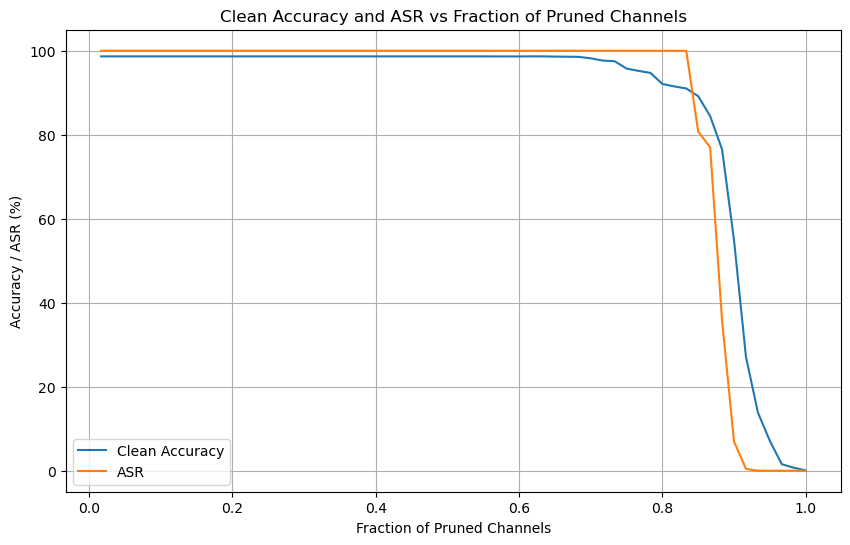

In [5]:
# Plot Clean Accuracy and ASR vs Fraction of Pruned Channels
pruned_fraction = np.arange(1,61)/60
plt.figure(figsize=(10, 6))
plt.plot(pruned_fraction, clean_acc, label='Clean Accuracy')
plt.plot(pruned_fraction, asrate, label='ASR')
plt.xlabel('Fraction of Pruned Channels')
plt.ylabel('Accuracy / ASR (%)')
plt.title('Clean Accuracy and ASR vs Fraction of Pruned Channels')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
cl_test_data_path = r'/Users/yogyasharma/Downloads/Lab3/data/cl/test.h5'         
bd_test_data_path = r'/Users/yogyasharma/Downloads/Lab3/data/bd/bd_test.h5' 

pruned_model_2_path = r'/Users/yogyasharma/model_threshold_2.h5'
pruned_model_4_path = r'/Users/yogyasharma/model_threshold_4.h5'
pruned_model_10_path = r'/Users/yogyasharma/model_threshold_10.h5'

# Loading the pruned models
pruned_model_2 = load_model(pruned_model_2_path)
pruned_model_4 = load_model(pruned_model_4_path)
pruned_model_10 = load_model(pruned_model_10_path)

pruned_model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
pruned_model_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
pruned_model_10.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Loading the test images
def load_test_data(filepath):
    data = h5py.File(filepath, 'r')
    x_test = np.array(data['data'])
    y_test = np.array(data['label'])
    x_test = x_test.transpose((0, 2, 3, 1))
    return x_test, y_test

cl_x_test, cl_y_test = load_test_data(cl_test_data_path)
bd_x_test, bd_y_test = load_test_data(bd_test_data_path)

In [7]:
# Make predictions on clean data
pruned_clean_2 = np.argmax(pruned_model_2.predict(cl_x_test), axis = 1)
pruned_clean_4 = np.argmax(pruned_model_4.predict(cl_x_test), axis = 1)
pruned_clean_10 = np.argmax(pruned_model_10.predict(cl_x_test), axis = 1)

# Make predictions on backdoored data
pruned_bd_2 = np.argmax(pruned_model_2.predict(bd_x_test), axis = 1)
pruned_bd_4 = np.argmax(pruned_model_4.predict(bd_x_test), axis = 1)
pruned_bd_10 = np.argmax(pruned_model_10.predict(bd_x_test), axis = 1)

# Evaluate clean data accuracy
acc_clean_2 = np.mean(np.equal(pruned_clean_2, cl_y_test))
acc_clean_4 = np.mean(np.equal(pruned_clean_4, cl_y_test))
acc_clean_10 = np.mean(np.equal(pruned_clean_10, cl_y_test))

# Evaluate ASR
acc_bd_2 = np.mean(np.equal(pruned_bd_2, bd_y_test))
acc_bd_4 = np.mean(np.equal(pruned_bd_4, bd_y_test))
acc_bd_10 = np.mean(np.equal(pruned_bd_10, bd_y_test))

print("Clean Data Accuracy for pruned models:")
print(f"Model with 2% threshold: {acc_clean_2 * 100}")
print(f"Model with 4% threshold: {acc_clean_4 * 100}")
print(f"Model with 10% threshold: {acc_clean_10 * 100}")

print("\nAttack Success Rate for pruned models:")
print(f"Model with 2% threshold: {acc_bd_2 * 100}")
print(f"Model with 4% threshold: {acc_bd_4 * 100}")
print(f"Model with 10% threshold: {acc_bd_10 * 100}")

401/401 [==============================] - 2s 4ms/step
Clean Data Accuracy for pruned models:
Model with 2% threshold: 95.90023382696803
Model with 4% threshold: 92.29150428682775
Model with 10% threshold: 84.54403741231489

Attack Success Rate for pruned models:
Model with 2% threshold: 100.0
Model with 4% threshold: 99.98441153546376
Model with 10% threshold: 77.20966484801247


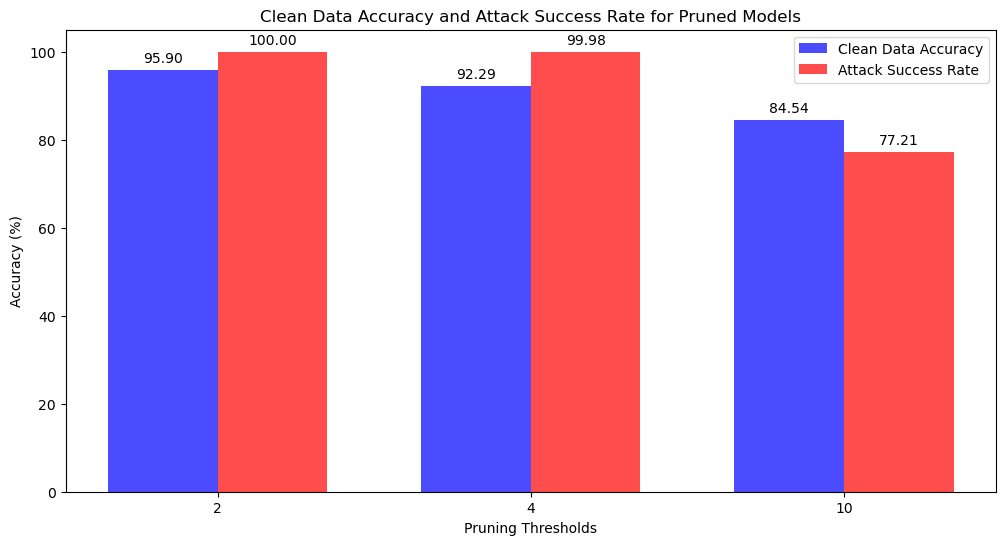

In [8]:
# Define the data
thresholds = [2, 4, 10]
acc_clean_data = [acc_clean_2 * 100, acc_clean_4 * 100, acc_clean_10 * 100]
acc_attack_success_rate = [acc_bd_2 * 100, acc_bd_4 * 100, acc_bd_10 * 100]

bar_width = 0.35
index = np.arange(len(thresholds))

# Plot grouped bar chart with markers
plt.figure(figsize=(12, 6))

plt.bar(index, acc_clean_data, bar_width, color='blue', alpha=0.7, label='Clean Data Accuracy')
plt.bar(index + bar_width, acc_attack_success_rate, bar_width, color='red', alpha=0.7, label='Attack Success Rate')

# Add markers
for i, value in enumerate(acc_clean_data):
    plt.text(i, value + 1, f'{value:.2f}', ha='center', va='bottom')

for i, value in enumerate(acc_attack_success_rate):
    plt.text(i + bar_width, value + 1, f'{value:.2f}', ha='center', va='bottom')

plt.xlabel('Pruning Thresholds')
plt.ylabel('Accuracy (%)')
plt.title('Clean Data Accuracy and Attack Success Rate for Pruned Models')
plt.xticks(index + bar_width / 2, thresholds)
plt.legend()

plt.show()


In [14]:
class GoodNet(keras.Model):
    def __init__(self, model_1, model_2):
        super(GoodNet, self).__init__()
        self.model_1 = model_1
        self.model_2 = model_2

    def predict(self, data):
        pred1 = np.argmax(self.model_1.predict(data), axis=1)
        pred2 = np.argmax(self.model_2.predict(data), axis=1)

        pred = np.where(pred1 == pred2, pred1, 1283)
        return pred

In [15]:
badnet_model = keras.models.load_model(model_path)

goodNet_2 = GoodNet(badnet_model, pruned_model_2)
goodNet_4 = GoodNet(badnet_model, pruned_model_4)
goodNet_10 = GoodNet(badnet_model, pruned_model_10)

goodNet_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
goodNet_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
goodNet_10.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Here we can see that the GoodNet models are being evaluated in the same way as to be done in eval.py. The argmax operation happens in the GoodNet class above and the classification accuracy is being calculated below for each model.
(Can't pass the model to the eval.py script, as that code preprocesses the input data, which isn't required here)

In case we need to pass the model to the eval script, I have attached GoodNet models in the repository, and can be given to the script if we remove the preprocessing step.

In [16]:
# Make predictions on clean data
predictions_clean_2 = goodNet_2.predict(cl_x_test)
predictions_clean_4 = goodNet_4.predict(cl_x_test)
predictions_clean_10 = goodNet_10.predict(cl_x_test)

# Make predictions on backdoored data
predictions_bd_2 = goodNet_2.predict(bd_x_test)
predictions_bd_4 = goodNet_4.predict(bd_x_test)
predictions_bd_10 = goodNet_10.predict(bd_x_test)

# Evaluate clean data accuracy
acc_clean_2 = np.mean(np.equal(cl_y_test, predictions_clean_2))
acc_clean_4 = np.mean(np.equal(cl_y_test, predictions_clean_4))
acc_clean_10 = np.mean(np.equal(cl_y_test, predictions_clean_10))

# Evaluate ASR
acc_bd_2 = np.mean(np.equal(bd_y_test, predictions_bd_2))
acc_bd_4 = np.mean(np.equal(bd_y_test, predictions_bd_4))
acc_bd_10 = np.mean(np.equal(bd_y_test, predictions_bd_10))

print("Clean Data Accuracy for GoodNet:")
print(f"Model with 2% threshold: {acc_clean_2 * 100}")
print(f"Model with 4% threshold: {acc_clean_4 * 100}")
print(f"Model with 10% threshold: {acc_clean_10 * 100}")

print("\nAttack Success Rate for GoodNet:")
print(f"Model with 2% threshold: {acc_bd_2 * 100}")
print(f"Model with 4% threshold: {acc_bd_4 * 100}")
print(f"Model with 10% threshold: {acc_bd_10 * 100}")


401/401 [==============================] - 2s 4ms/step
Clean Data Accuracy for GoodNet:
Model with 2% threshold: 95.74434918160561
Model with 4% threshold: 92.1278254091972
Model with 10% threshold: 84.3335931410756

Attack Success Rate for GoodNet:
Model with 2% threshold: 100.0
Model with 4% threshold: 99.98441153546376
Model with 10% threshold: 77.20966484801247


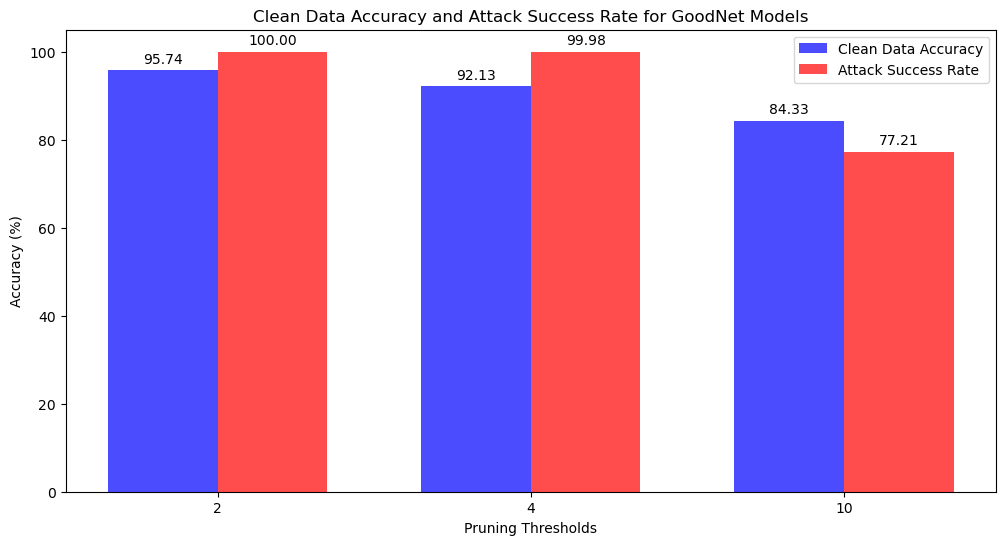

In [12]:
# Define the data
thresholds = [2, 4, 10]
acc_clean_data = [acc_clean_2 * 100, acc_clean_4 * 100, acc_clean_10 * 100]
acc_attack_success_rate = [acc_bd_2 * 100, acc_bd_4 * 100, acc_bd_10 * 100]

bar_width = 0.35
index = np.arange(len(thresholds))

# Plot grouped bar chart with markers
plt.figure(figsize=(12, 6))

plt.bar(index, acc_clean_data, bar_width, color='blue', alpha=0.7, label='Clean Data Accuracy')
plt.bar(index + bar_width, acc_attack_success_rate, bar_width, color='red', alpha=0.7, label='Attack Success Rate')

# Add markers
for i, value in enumerate(acc_clean_data):
    plt.text(i, value + 1, f'{value:.2f}', ha='center', va='bottom')

for i, value in enumerate(acc_attack_success_rate):
    plt.text(i + bar_width, value + 1, f'{value:.2f}', ha='center', va='bottom')

plt.xlabel('Pruning Thresholds')
plt.ylabel('Accuracy (%)')
plt.title('Clean Data Accuracy and Attack Success Rate for GoodNet Models')
plt.xticks(index + bar_width / 2, thresholds)
plt.legend()

plt.show()
